#**Ejercicio 02 - Pronóstico de la evolución de pacientes con diabetes**

##**Descripción del problema real**
Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

##**Descripción del problema en términos de los datos**
Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo datos/diabetes.csv. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

##**Aproximaciones posibles**
En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

#**Carga de datos**
En el siguiente bloque de código se cargan los datos de los pacientes con diabetes para el pronóstico de su evolución. Los datos se obtienen en formato _csv_ desde el repositorio de github. Luego se almacenan en un _DataFrame_ de _pandas_ como se muestra en el método _head()_.
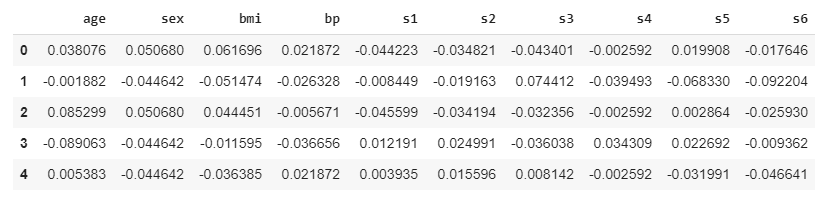

In [0]:
import pandas as pd
#LECTURA DE DATOS
pdDiabetes = pd.read_csv("https://raw.githubusercontent.com/ANN-2019-2/evaluacion-DavidMosquera/master/datos/diabetes.csv")
pdDiabetesEntradas = pdDiabetes[["age","sex","bmi","bp","s1","s2","s3","s4","s5","s6"]]
pdDiabetesSalidas = pdDiabetes[["Y"]]
pdDiabetesEntradas.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


#**Clase para la evaluación de los modelos lineales y NO lineales**
En el siguiente bloque de código se define la clase Modelo con los siguientes atributos: pandaEntradas, pandaSalidas, umbral y segmentos. Estos atributos permiten ejecutar los siguientes métodos para la evaluación de los modelos lineales y no lineales:
* **_iniciarTransformaciones_(self)**: Este método permite generar las diferentes transformaciones de las entradas y salidas. Primero, se aplican a las entradas las funciones matemáticas de raíz cuadrada, logaritmo natural, raíz cúbica, potencia de dos y la función exponencial. Luego, se guarda el resultado de la transformación en una nueva columna cuyo nombre sigue la convención "transformacionnombre"—_e.g._ cuando se le aplica la transformación raíz cuadrada "sqrt" a la entrada "age", se crea una nueva columna con el resultado de la transformación con nombre "sqrtage". Finalmente, se aplican estas mismas funciones matemáticas a las salidas y se almacena el resultado en una nueva columna que sigue la convención "transforamcionY". Es importante resaltar que, debido a las restricciones de dominio de las funciones matemáticas—_e.g._ valores menores que cero en la raíz cuadrada—, se desplazan los valores de entrada un escalar para evitar estas restricciones.
* **_seleccionModelo_(self)**: Este método permite seleccionar el mejor modelo lineal a partir de las entradas y salidas que se utilizan. En éste se prueban las diferentes transformaciones como entradas del modelo y se escogen las que mejoren el modelo según el umbral de mejoría. Además, se obtienen las entradas que mejor describen los datos de salida y se descartan las que tienen poco poder descriptivo de las salidas. Finalmente, se prueba el modelo lineal con el promedio del MAE de test de los "n" segmentos que se establecen en el _CrossValidation_.
* **_seleccionModeloNoLineal_(self)**: Este método permite seleccionar el mejor modelo NO lineal a partir de las entradas y salidas del mejor modelo lineal. En éste se prueban redes neuronales de 1 a 15 neuronas en la capa oculta, con función de activación logística y 0.001 de learning_rate. Finalmente, se selecciona el mejor modelo NO lineal a partir del promedio del MAE de test de los "n" segmentos que se establecen en el _CrossValidation_.

In [0]:
from sklearn import linear_model
import sklearn.neural_network
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import numpy as np

class Modelo: 
  def __init__ (self, pandaEntradas, pandaSalidas, umbral = 0.1, segmentos = 10):
    self.pandaEntradas = pandaEntradas
    self.pandaSalidas = pandaSalidas
    self.umbral = umbral
    self.segmentos = segmentos

  def iniciarTransformaciones(self):
    self.transformaciones = ["sqrt","log","sqrt3","pow2","e"]
    self.columnasOriginalesEntrada = self.pandaEntradas.columns.copy()
    #CICLO DE TRANSFORMACION DE COLUMNAS DE ENTRADA
    for columna in self.columnasOriginalesEntrada:
      for transformacion in self.transformaciones:
        if transformacion == "sqrt":
          self.pandaEntradas[transformacion + columna] = np.power(self.pandaEntradas[columna]+0.5,1/2)
        elif transformacion == "log":
          self.pandaEntradas[transformacion + columna] = np.log(self.pandaEntradas[columna]+0.5)
        elif transformacion == "sqrt3":
          self.pandaEntradas[transformacion + columna] = np.power(self.pandaEntradas[columna]+0.5,1/3)
        elif transformacion == "pow2":
          self.pandaEntradas[transformacion + columna] = np.power(self.pandaEntradas[columna],2)
        elif transformacion == "e":
          self.pandaEntradas[transformacion + columna] = np.exp(self.pandaEntradas[columna]+0.5)

    #CICLO DE TRANSFORMACION DE COLUMNAS DE SALIDA
    for transformacion in self.transformaciones:
      if transformacion == "sqrt":
        self.pandaSalidas[transformacion+"Y"] = np.power(self.pandaSalidas["Y"],1/2)
      elif transformacion == "log":
        self.pandaSalidas[transformacion+"Y"] = np.log(self.pandaSalidas["Y"])
      elif transformacion == "sqrt3":
        self.pandaSalidas[transformacion+"Y"] = np.power(self.pandaSalidas["Y"],1/3)
      elif transformacion == "pow2":
        self.pandaSalidas[transformacion+"Y"] = np.power(self.pandaSalidas["Y"],2)
      elif transformacion == "e":
        self.pandaSalidas[transformacion+"Y"] = np.exp(self.pandaSalidas["Y"])

  def seleccionModelo(self):
    maeTest = float("inf")
    columnasDelModelo = []
    indiceEntrenamiento = int(len(self.pandaSalidas)*0.8)

    for columna in self.columnasOriginalesEntrada:
      mejoria = False
      columnasDePrueba = columnasDelModelo.copy()
      
      columnasDePrueba.append(columna)

      pdEntradasTrain = self.pandaEntradas[columnasDePrueba][0:indiceEntrenamiento]
      pdSalidasTrain = self.pandaSalidas[["Y"]][0:indiceEntrenamiento]

      pdEntradasTest = self.pandaEntradas[columnasDePrueba][indiceEntrenamiento:]
      pdSalidasTest = self.pandaSalidas[["Y"]][indiceEntrenamiento:]

      #Regresion
      regresion = linear_model.LinearRegression()
      regresion.fit(pdEntradasTrain, pdSalidasTrain)
      
      #Test
      pronosticos = []
      for casoPrueba in range(0,len(pdEntradasTest)):
        pronostico = regresion.predict([np.array(pdEntradasTest)[casoPrueba]])
        pronosticos.append(pronostico[0][0])
      
      #MAE
      maeModelo = mean_absolute_error(pdSalidasTest["Y"],pronosticos)

      if maeTest - maeModelo > self.umbral:
        mejoria = True
        maeTest = maeModelo
        mejorRegresion = regresion
        combinacion = columna
        pronosticoMejorRegresion = pronosticos.copy()
        testMejorRegresion = pdSalidasTest["Y"].copy()

      #TRANSFORMACIONES
      for transformacion in self.transformaciones: 
        columnasDePrueba = columnasDelModelo.copy()
        columnasDePrueba.append(transformacion+columna)
        
        pdEntradasTrain = self.pandaEntradas[columnasDePrueba][0:indiceEntrenamiento]
        pdSalidasTrain = self.pandaSalidas[["Y"]][0:indiceEntrenamiento]

        pdEntradasTest = self.pandaEntradas[columnasDePrueba][indiceEntrenamiento:]
        pdSalidasTest = self.pandaSalidas[["Y"]][indiceEntrenamiento:]

        #Regresion
        regresion = linear_model.LinearRegression()
        regresion.fit(pdEntradasTrain, pdSalidasTrain)
        
        #Test
        pronosticos = []
        for casoPrueba in range(0,len(pdEntradasTest)):
          pronostico = regresion.predict([np.array(pdEntradasTest)[casoPrueba]])
          pronosticos.append(pronostico[0][0])
        
        
        maeModelo = mean_absolute_error(pdSalidasTest["Y"],pronosticos)

        if maeTest - maeModelo > self.umbral:
          mejoria = True
          maeTest = maeModelo
          mejorRegresion = regresion
          combinacion = transformacion + columna
          pronosticoMejorRegresion = pronosticos.copy()
          testMejorRegresion = pdSalidasTest["Y"].copy()
    
      if mejoria:
        columnasDelModelo.append(combinacion)

    self.columnasDelModelo = columnasDelModelo
    self.maeModelo = maeTest

    #PRUEBA CON TRANSFROMACION DE LAS Y
    mejoria = False
    combinacionY = "Y"
    self.combinacionY = "Y"
    for transformacion in self.transformaciones: 
      columnasDePrueba = columnasDelModelo.copy()
      columnasDePrueba.append(transformacion+columna)
      
      pdEntradasTrain = self.pandaEntradas[self.columnasDelModelo][0:indiceEntrenamiento]
      pdSalidasTrain = self.pandaSalidas[[transformacion+"Y"]][0:indiceEntrenamiento]

      pdEntradasTest = self.pandaEntradas[self.columnasDelModelo][indiceEntrenamiento:]
      pdSalidasTest = self.pandaSalidas[["Y"]][indiceEntrenamiento:]

      #Regresion
      regresion = linear_model.LinearRegression()
      regresion.fit(pdEntradasTrain, pdSalidasTrain)
      
      #Test
      pronosticos = []
      for casoPrueba in range(0,len(pdEntradasTest)):
        pronostico = regresion.predict([np.array(pdEntradasTest)[casoPrueba]])
        pronosticos.append(pronostico[0][0])
      
      #Transformacion inversa
      if transformacion == "sqrt":
        pronosticos = np.power(pronosticos,2)
      elif transformacion == "log":
        pronosticos = np.exp(pronosticos)
      elif transformacion == "sqrt3":
        pronosticos = np.power(pronosticos,3)
      elif transformacion == "pow2":
        pronosticos = np.power(pronosticos,1/2)
      elif transformacion == "e":
        pronosticos = np.log(pronosticos)

      #MAE
      try:
        maeModelo = mean_absolute_error(pdSalidasTest["Y"],pronosticos)
      except:
        maeModelo = float("inf")

      if self.maeModelo - maeModelo > self.umbral:
        mejoria = True
        self.maeModelo = maeModelo
        combinacionY = transformacion+"Y"
        mejorRegresion = regresion
        pronosticoMejorRegresion = pronosticos.copy()
        testMejorRegresion = pdSalidasTest["Y"].copy()
    
    if mejoria:
      self.combinacionY = combinacionY

    #CROSS VALIDATION
    pdSegmentosEntrada = np.array_split(self.pandaEntradas[self.columnasDelModelo], self.segmentos)
    pdSegmentosSalida = np.array_split(self.pandaSalidas[[self.combinacionY]], self.segmentos)
    maes = []
    for indiceSegmento in range(0, self.segmentos):
      #SEPARAMOS EL SEGMENTO DE ENTRENAMIENTO CON EL DE VALIDACION DE FORMA DINÁMICA
      pdEntradasTrain = pd.DataFrame()
      pdSalidasTrain = pd.DataFrame()

      pdEntradasTest = pd.DataFrame()
      pdSalidasTest = pd.DataFrame

      for indiceSegmentoSeleccion in range (0, self.segmentos):
        if indiceSegmentoSeleccion != indiceSegmento:
          pdEntradasTrain = pdEntradasTrain.append(pdSegmentosEntrada[indiceSegmentoSeleccion].copy())
          pdSalidasTrain = pdSalidasTrain.append(pdSegmentosSalida[indiceSegmentoSeleccion].copy())
        else:
          pdEntradasTest = pdSegmentosEntrada[indiceSegmentoSeleccion].copy()
          pdSalidasTest = pdSegmentosSalida[indiceSegmentoSeleccion].copy()
        
      #Regresion
      regresion = linear_model.LinearRegression()
      regresion.fit(pdEntradasTrain, pdSalidasTrain)

      #Test
      pronosticos = []
      for casoPrueba in range(0,len(pdEntradasTest)):
        pronostico = regresion.predict([np.array(pdEntradasTest)[casoPrueba]])
        pronosticos.append(pronostico[0][0])
      
      #MAE
      try:
        maes.append(mean_absolute_error(pdSalidasTest["Y"],pronosticos))
      except:
        pass
      
      self.maeModelo = np.mean(maes)
      self.regresion = regresion
      self.test = pdSalidasTest["Y"].copy()
      self.pronostico = pronosticos.copy()

  def seleccionModeloNoLineal(self):
    #CONSTRUIMOS EL MODELO NO LINEAL, DETERMINAMOS EL NUMERO DE NEURONAS EN LA CAPA OCULTA
    indiceEntrenamiento = int(len(self.pandaSalidas)*0.8)
    maeTest = float("inf")
    self.errorFit = []
    self.errorTrain = []
    self.scalerEntradas = MinMaxScaler()
    self.scalerSalidas = MinMaxScaler()

    pdSegmentosEntrada = np.array_split(self.pandaEntradas[self.columnasDelModelo], self.segmentos)
    pdSegmentosSalida = np.array_split(self.pandaSalidas[[self.combinacionY]], self.segmentos)


    for numeroCapaOculta in range (1, 15):
      
      mlp = sklearn.neural_network.MLPRegressor(
                  hidden_layer_sizes = (numeroCapaOculta,),  # Una capa oculta con una neurona
                  activation = 'logistic',    #  {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
                  solver = 'sgd',             #  {‘lbfgs’, ‘sgd’, ‘adam’}
                  learning_rate_init = 0.001,   # Valor de la tasa de aprendizaje
                  learning_rate = 'adaptative', # La tasa no se adapta automáticamente
                  verbose = False,            # Reporte del proceso de optimización
                  shuffle = True,             #
                  tol = 1e-10,                 #
                  max_iter = 25000,          # Número máximo de iteraciones       
                  nesterovs_momentum = True,
                  warm_start = False) #

      #CROSS VALIDATION
      maes = []
      loss = []
      for indiceSegmento in range(0,self.segmentos):
        #SEPARAMOS EL SEGMENTO DE ENTRENAMIENTO CON EL DE VALIDACION DE FORMA DINÁMICA
        pdEntradasTrain = pd.DataFrame()
        pdSalidasTrain = pd.DataFrame()

        pdEntradasTest = pd.DataFrame()
        pdSalidasTest = pd.DataFrame

        for indiceSegmentoSeleccion in range (0, self.segmentos):
          if indiceSegmentoSeleccion != indiceSegmento:
            pdEntradasTrain = pdEntradasTrain.append(pdSegmentosEntrada[indiceSegmentoSeleccion].copy())
            pdSalidasTrain = pdSalidasTrain.append(pdSegmentosSalida[indiceSegmentoSeleccion].copy())
          else:
            pdEntradasTest = pdSegmentosEntrada[indiceSegmentoSeleccion].copy()
            pdSalidasTest = pdSegmentosSalida[indiceSegmentoSeleccion].copy()

        pdEntradasTrain = pd.DataFrame(self.scalerEntradas.fit_transform(pdEntradasTrain))
        pdSalidasTrain = pd.DataFrame(self.scalerSalidas.fit_transform(pdSalidasTrain))

        pdEntradasTest = pd.DataFrame(self.scalerEntradas.fit_transform(pdEntradasTest))
        pdSalidasTest = pd.DataFrame(self.scalerSalidas.fit_transform(pdSalidasTest))

        mlp.fit(pdEntradasTrain, pdSalidasTrain.values.ravel())

        loss.append(mlp.loss_)
        pronosticos = []
        for casoPrueba in range(0,len(pdEntradasTest)):
          pronostico = mlp.predict([np.array(pdEntradasTest)[casoPrueba]])
          pronosticos.append(pronostico[0])
      
        pronostico_inv = self.scalerSalidas.inverse_transform(pd.DataFrame(pronosticos.copy()))
        test_inv = self.scalerSalidas.inverse_transform(pd.DataFrame(pdSalidasTest.copy()))

        maes.append(mean_absolute_error(test_inv,pronostico_inv))
      
      #EL ERROR PROMEDIO DEL CROSS VALDIATION ES EL QUE SE COMPARA PARA ELEGIR EL MEJOR MODELO
      #ASÍ SE COMPRUBA LA ROBUSTEZ DEL MODELO
      maeModelo = np.mean(maes)
      self.errorFit.append(np.mean(loss))
      self.errorTrain.append(maeModelo)
      if maeTest - maeModelo > self.umbral:
        maeTest = maeModelo
        self.maeMLP = maeModelo
        numeroNeuronasCapaOculta1 = numeroCapaOculta
        numeroNeuronasCapaOculta2 = 0
        mejorMLP = mlp
        pronosticoMejorMLP = pronostico_inv.copy()
        testMejorMLP = test_inv.copy()
    
    self.numeroNeuronasCapaOculta1 = numeroNeuronasCapaOculta1
    self.numeroNeuronasCapaOculta2 = numeroNeuronasCapaOculta2
    self.mlp = mejorMLP
    self.pronosticoMLP = pronosticoMejorMLP
    self.testMLP = testMejorMLP
    self.maes = maes



#**Modelo lineal con transformaciones**
En el siguiente bloque de código, se ejecutan los métodos de la clase Modelo para seleccionar el mejor modelo lineal con transformaciones en entradas y salidas. 

In [0]:
#MODELO BASE LINEAL CON TRANSFORMACIONES
modelo = Modelo(pandaEntradas = pdDiabetesEntradas.copy(), pandaSalidas = pdDiabetesSalidas.copy(), umbral = 0.01, segmentos = 10)
modelo.iniciarTransformaciones()
modelo.seleccionModelo()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in log


##**Resultado**
Luego de evaluar los modelos lineales, se obtiene que las entradas significativas con sus respectivas transformaciones con un umbral de mejora de 0.1 son: 
* **eage**: La edad del paciente con la función exponencial como transformación.
* **sqrtbmi**: El bmi del paciente con la función raíz cuadrada como transformación.
* **ebp**: El bp del paciente con la función exponencial como transformación.
* **s2**: El s2 del paciente sin transformación.
* **logs3**: El s3 del paciente con la función logaritmo natural como transformación.
* **logs4**: El s4 del paciente con la función logaritmo natural como transformación.
* **sqrts5**: El s5 del paciente con la función raíz cuadrada como transformación.
* **pow2s6**: El s6 del paciente con la función potencia de dos como transformación.

Las entradas que se descartaron junto con sus transformaciones por no superar el umbral de mejora son "sex" y "s1".

Para las salidas no se obtuvo una mejora significativa que superase el umbral, por lo que la salida permanece sin transformación.

Finalmente, se obtiene la gráfica de pronóstico y de dispersión en test del mejor modelo lineal junto con su MAE promedio de los 10 segmentos del _CrossValidation_, que en este caso es igual a 44.97 aproximadamente. 

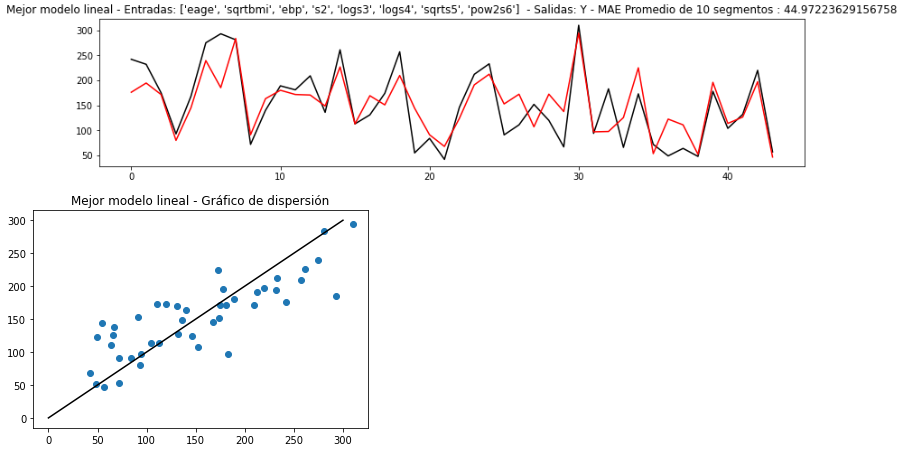

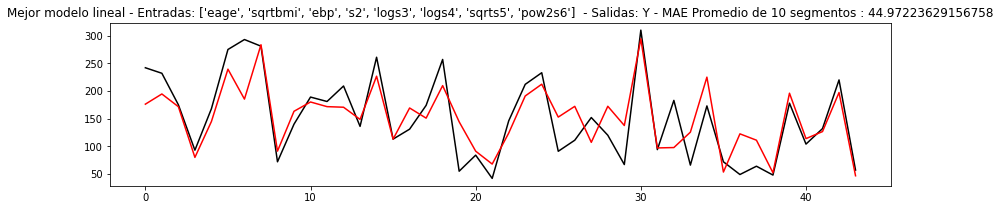

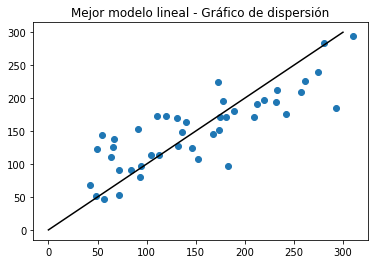

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.title("Mejor modelo lineal - Entradas: " + str(modelo.columnasDelModelo) + "  - Salidas: " + modelo.combinacionY+" - MAE Promedio de "+ str(modelo.segmentos)+" segmentos : "+str(modelo.maeModelo))
plt.plot(np.array(modelo.test), color="black")
plt.plot(np.array(modelo.pronostico), color="red")
plt.figure()
plt.title("Mejor modelo lineal - Gráfico de dispersión")
plt.plot([0,300],[0,300], color = "black")
plt.scatter(np.array(modelo.test), np.array(modelo.pronostico))

#**Modelo NO lineal**
En el siguiente bloque de código, se selecciona el mejor modelo NO lineal a partir del mejor modelo lineal base.

In [0]:
modelo.seleccionModeloNoLineal()

##**Resultados**
Luego de evaluar los modelos NO lineales, se obtiene que el mejor modelo NO lineal es una red neuronal con 2 neuronas en su capa oculta. Además, se observa que el error de entrenamiento decrese según se adicionan neuronas en la capa oculta. Finalmente, se elige el modelo NO lineal con el menor MAE promedio de los "n" segmentos del _CrossValidation_, que en este caso es de 44.20 aproximadamente.

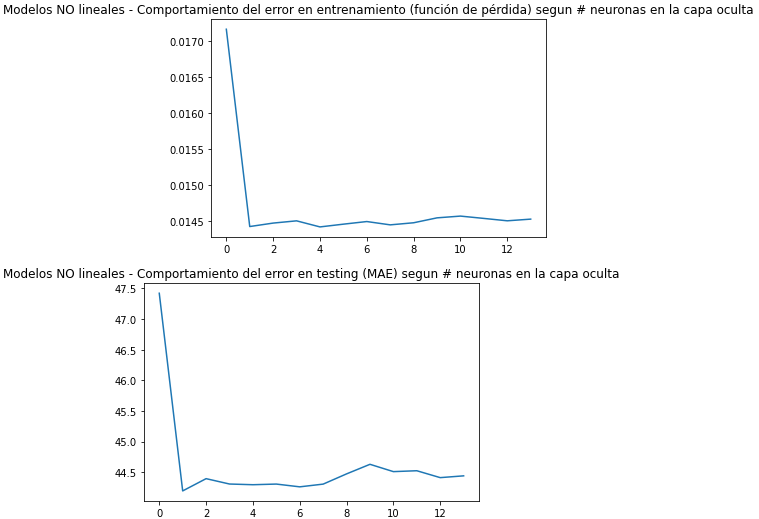

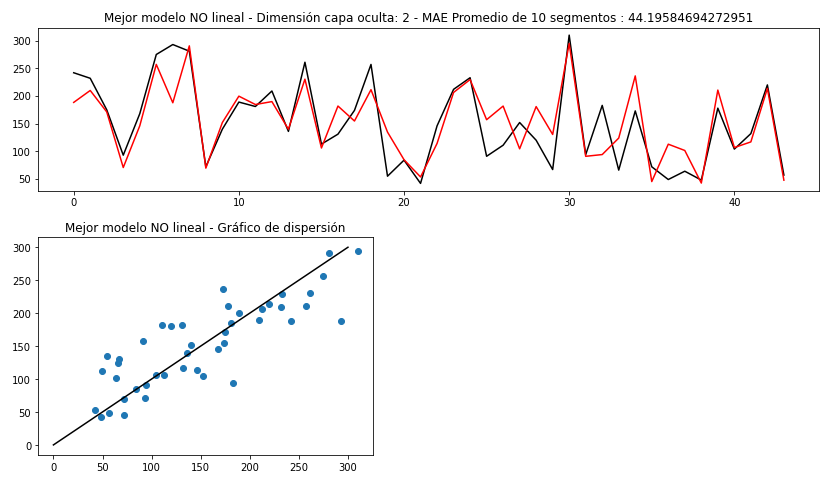

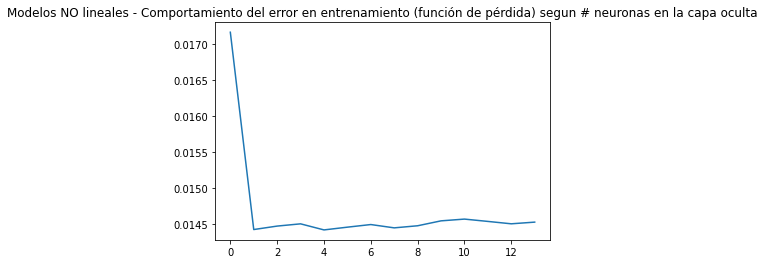

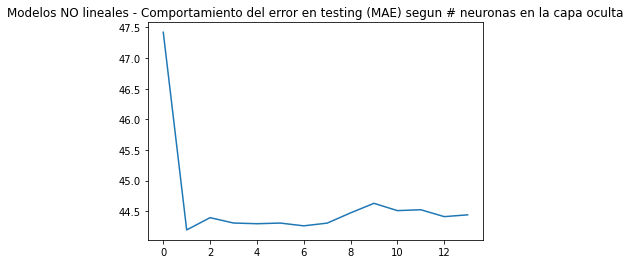

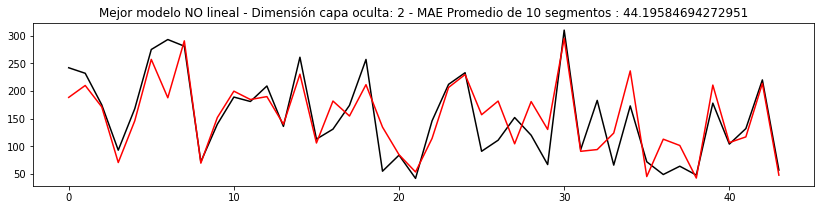

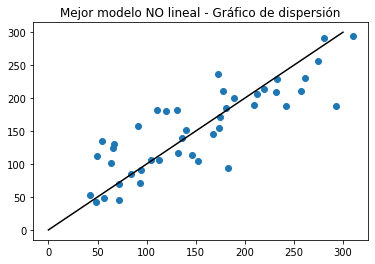

In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Modelos NO lineales - Comportamiento del error en entrenamiento (función de pérdida) segun # neuronas en la capa oculta")
plt.plot(np.array(modelo.errorFit))
plt.figure()
plt.title("Modelos NO lineales - Comportamiento del error en testing (MAE) segun # neuronas en la capa oculta")
plt.plot(np.array(modelo.errorTrain))
plt.figure(figsize=(14,3))
plt.title("Mejor modelo NO lineal - Dimensión capa oculta: " +str(modelo.numeroNeuronasCapaOculta1) + " - MAE Promedio de "+ str(modelo.segmentos)+" segmentos : "+str(modelo.maeMLP))
plt.plot(np.array(modelo.testMLP), color="black")
plt.plot(np.array(modelo.pronosticoMLP), color="red")
plt.figure()
plt.title("Mejor modelo NO lineal - Gráfico de dispersión")
plt.plot([0,300],[0,300], color = "black")
plt.scatter(np.array(modelo.testMLP), np.array(modelo.pronosticoMLP))

#**Conclusión**
En este código se evalúan diferentes modelos lineales y NO lineales para el pronóstico de la evolución de pacientes con diabetes. En cada una de estas evaluaciones involucra _CrossValidation_ para asegurar la robustez de los modelos. Según se observa, el mejor modelo NO lineal posee un menor MAE promedio para los 10 segmentos del _CrossValidation_ a comparación del mejor modelo lineal. Sin embargo, la reducción del MAE para los 10 segmentos tiene un valor menor a 1.0, lo que puede ser no tan significativo con respecto al mejor modelo lineal. Finalmente, se comprueba que el entrenamiento del modelo NO lineal es adecuado ya que el error de entrenamiento decrese conforme se aumenta el número de neuronas en la capa oculta.